Source : [Build a Retrieval Augmented Generation (RAG) App: Part 1 | 🦜️🔗 LangChain](https://python.langchain.com/docs/tutorials/rag/)

In [4]:
import getpass
import os
import dotenv

dotenv.load_dotenv()

PROVIDER = os.environ["PROVIDER"]
MODEL = os.environ["MODEL"]
URL = os.environ.get("URL")
EMBEDDING_MODEL = os.environ["EMBEDDING_MODEL"]

In [5]:
from langchain.chat_models import init_chat_model
if PROVIDER == "openai":
  llm = init_chat_model(MODEL, model_provider=PROVIDER)
if PROVIDER == "ollama":
  llm = init_chat_model(MODEL, model_provider=PROVIDER, base_url=URL)
  

In [6]:
if PROVIDER == "openai":
  if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
  from langchain_openai import OpenAIEmbeddings
  embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
elif PROVIDER == "ollama":
  from langchain_community.embeddings import OllamaEmbeddings
  embeddings = OllamaEmbeddings(model=EMBEDDING_MODEL, base_url=URL)

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [8]:
from langchain import hub

# Define prompt for question-answering
prompt = hub.pull("sa2812/rag-prompt")

print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'sa2812', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': 'b059471402c64f7e320f429ab20064c0fdca65350e1296519bbeb70052a470ca'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


KeyboardInterrupt: 

In [56]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])


Task Decomposition is a technique used in planning where a complicated task is broken down into smaller, simpler steps. This allows an agent to "think step by step" and utilize more test-time computation. The goal is to transform big tasks into multiple manageable tasks, making it easier for the model to understand and solve complex problems.


In [57]:
response = graph.invoke({"question": "Create a table of contents of 10 points for the document?"})
print(response["answer"])

print(f'Context: {response["context"]}\n\n')
print(f'Answer: {response["answer"]}')



I don't know how to create a table of contents for a document. I don't have enough information about the specific requirements or format of the table of contents. If you provide more context, I can try to assist you further.
Context: [Document(id='b598e62d-7f38-42ea-99c6-f4f26530e4b5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='(2) Model selection: LLM distributes the tasks to expert models, where the request is framed as a multiple-choice question. LLM is presented with a list of models to choose from. Due to the limited context length, task type based filtration is needed.\nInstruction:\n\nGiven the user request and the call command, the AI assistant helps the user to select a suitable model from a list of models to process the user request. The AI assistant merely outputs the model id of the most appropriate model. The output must be in a strict JSON format: "id": "id", "reason": "your detail reason for the choice". We have a list of m

In [58]:
response = graph.invoke({"question": "Summarize the document in 10 points?"})
print(response["answer"])

print(f'Context: {response["context"]}\n\n')



I don't know how to summarize the document in 10 points without more context about its content. The provided text appears to be part of an article discussing HuggingGPT and ReAct, but it doesn't provide enough information for a concise summary.
Context: [Document(id='f1e51594-73d5-4099-bc2f-5a54b2fad7d6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe system comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.\nInstruction:'), Document(id='b598e62d-7f38-42ea-99c6-f4f26530e4b5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='(2) Model selection: LLM distributes the tasks to expert models,

In [59]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='a83e80c1-a658-4839-b773-3c33bca89b78', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 9. Comparison of MIPS algorithms, measured in recall@10. (Image source: Google Blog, 2020)\nCheck more MIPS algorithms and performance comparison in ann-benchmarks.com.\nComponent Three: Tool Use#\nTool use is a remarkable and distinguishing characteristic of human beings. We create, modify and utilize external objects to do things that go beyond our physical and cognitive limits. Equipping LLMs with external tools can significantly extend the model capabilities.'), Document(id='118cd395-22b0-4b7b-99ae-9dccb8b2564d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nCha

In [60]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task| Decom|position| is| a| technique| where| complex| tasks| are| broken| down| into| smaller|,| simpler| steps| by| instruct|ing| an| agent| or| model| to| "|think| step| by| step|".| This| approach| helps| transform| big| tasks| into| multiple| manageable| tasks|,| allowing| for| more| efficient| computation| and| interpretation| of| the| model|'s| thinking| process|.| It| enables| agents| to| learn| from| their| mistakes| and| improve| over| time|.||

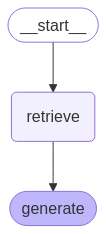

In [61]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

